# Audio Example

ใน Tutorial นี้ เราจะลองเอาความรู้ทางด้าน signal processing มาเล่นกับไฟล์เสียงดู

เราเริ่มต้นด้วยการ import สิ่งที่เราจะใช้งานมา

In [1]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
from sklearn.decomposition import FastICA
import IPython
import IPython.display as ipd

## Download Audios

Download ไฟล์เสียงผ่านคำสั่ง `wget` ซึ่งเป็นไฟล์เสียงที่จำลองสถานการณ์ต่อไปนี้

ในห้องมีคนอยู่สองคน คนแรกนั่งฟัง lecture ของ Brain Building Blocks ในขณะที่คนที่สองกำลังหัดเล่นกีตาร์ โดยไฟล์เสียงที่เราดาวน์โหลดมาจะมีสองไฟล์ ประกอบด้วย

1.   mixed_near_lecture.wav เป็นไฟล์เสียงที่อัดมาจากโทรศัพท์มือถือที่อยู่ใกล้กับคนที่ฟัง lecture อยู่

2.   mixed_near_music.wav เป็นไฟล์เสียงที่อัดมาจากโทรศัพท์มือถือที่อยู่ใกล้กับคนที่หัดเล่นกีตาร์

ทั้งสองไฟล์นี้ถูกอัดพร้อม ๆ กัน


In [ ]:
!wget -O mixed_near_lecture.wav https://github.com/ichatnun/brainCodeCamp2023/raw/main/Fundamentals/SignalProcessing/data/mixed_near_lecture.wav
!wget -O mixed_near_music.wav https://github.com/ichatnun/brainCodeCamp2023/raw/main/Fundamentals/SignalProcessing/data/mixed_near_music.wav

--2023-08-09 10:00:33--  https://github.com/ichatnun/brainCodeCamp/raw/main/Fundamentals/SignalProcessing/data/mixed_near_lecture.wav
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ichatnun/brainCodeCamp/main/Fundamentals/SignalProcessing/data/mixed_near_lecture.wav [following]
--2023-08-09 10:00:34--  https://raw.githubusercontent.com/ichatnun/brainCodeCamp/main/Fundamentals/SignalProcessing/data/mixed_near_lecture.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 786278 (768K) [audio/wav]
Saving to: ‘mixed_near_lecture.wav’

mixed_near_lecture. 100%[===================>] 767.85K  --.-KB/s  

## Listen to the Audio Signals
ทำการโหลดไฟล์เสียงทั้ง 2 ไฟล์มาเก็บไว้ใน variable และลองฟังเสียงที่อัดมาโดยการใช้ `IPython.display.Audio`

In [3]:
# โหลดไฟล์เสียงทั้ง 2 ไฟล์มา
mixed_near_lecture, sampling_rate = librosa.load('mixed_near_lecture.wav')
mixed_near_music, _ = librosa.load('mixed_near_music.wav')

# print sampling rate ออกมาดู
print(f"Sampling rate = {sampling_rate/1000} kHz")

# แสดงปุ่มสำหรับกดฟังเสียง
print("Near lecture")
ipd.display(IPython.display.Audio(mixed_near_lecture, rate=sampling_rate))
print("Near guitar")
ipd.display(IPython.display.Audio(mixed_near_music, rate=sampling_rate))

Sampling rate = 22.05 kHz
Near lecture


Near guitar


## Independent Component Analysis (ICA)

จากที่ได้ลองฟังเสียงดูจะเห็นว่าไฟล์เสียงทั้งสอง (mixed signals) มีเสียงอย่างน้อย 2 ชนิดผสมกัน ประกอบด้วยเสียงคนพูดและเสียงกีตาร์ (source signals) ซึ่งทั้งสองไฟล์มีความแตกต่างกันเล็กน้อยตรงที่มีความดังของเสียงคนพูดและเสียงกีตาร์ที่แตกต่างกัน

ถ้าเกิดว่าเราสนใจแยกเสียงที่มาจากแต่ละ source ใน mixed signal ออกจากกัน เราสามารถใช้เทคนิคพื้นฐาน เช่น Independent Component Analysis (ICA) ดูได้

โจทย์ประเภทนี้มีชื่อเรียกว่า source separation, blind signal separation หรือ blind source separation

<br>

ในตัวอย่างนี้ เราจะลองใช้ `sklearn.decomposition.FastICA` ในการแยก source signal ออกจากกันดูว่าจะแยกสำเร็จหรือไม่ โดยเราจะกำหนดล่วงหน้าว่ามี source signals อยู่ 2 สัญญาณ


In [4]:
# กำหนดจำนวน components ที่จะใช้สำหรับ ICA
n_components = 2

# เอา mixed signals มารวมกันไว้ใน variable ที่ชื่อว่า mixed_concat
mixed_concat = np.concatenate((np.expand_dims(mixed_near_lecture, axis=-1), np.expand_dims(mixed_near_music, axis=-1)), axis=1)

# ลองใช้ ICA เพื่อพยายามแยก source signals จาก mixed signals ดู
transformer = FastICA(n_components=n_components, whiten='unit-variance', random_state=128)
source_estimated = transformer.fit_transform(mixed_concat)

ลองฟังเสียง source signals ที่ ICA ให้มา

In [5]:
# ลองฟังเสียงของแต่ละ source ที่ ICA ให้มา
for idx in range(n_components):

    # Normalize ทุกจุดในแต่ละ source signal ด้วยค่าสูงสุดคือค่าสัมบูรณ์ของมัน
    source_estimated[:, idx] /= np.max(np.abs(source_estimated[:, idx]))

    # แสดงปุ่มสำหรับกดฟังเสียง
    print(f"Source {idx+1}")
    ipd.display(IPython.display.Audio(source_estimated[:, idx], rate=sampling_rate))

Source 1


Source 2


ในตัวอย่างจำลองนี้ ICA สามารถแยกเสียงกีตาร์ออกจากเสียง lecture ได้ดีพอสมควร

**หมายเหตุ**


1.   ในหลายสถานการณ์ ICA ก็ไม่สามารถแยก source แต่ละอันออกจากกัน เราอาจจะต้องพึ่งพาเทคนิคอื่น ๆ ที่มีสมมติฐานและความซับซ้อนแตกต่างกันออกไป
2.   ICA มักจะถูกนำมาใช้ในการกำจัด eye movement artifacts ออกจากข้อมูล electroencephalogram (EEG)

<br>

---
เครื่องมือที่เป็นที่นิยมสำหรับใช้ในการวิเคราะห์ไฟล์เสียง ที่เราได้ทำความรู้จักกันใน tutorial ที่แล้ว ก็คือการดู spectrogram ซึ่งเป็นสิ่งที่ให้ข้อมูลทั้งใน time domain และ frequency domain

เราจะมาลองดู spectrogram ของ source signals ทั้งสองกัน


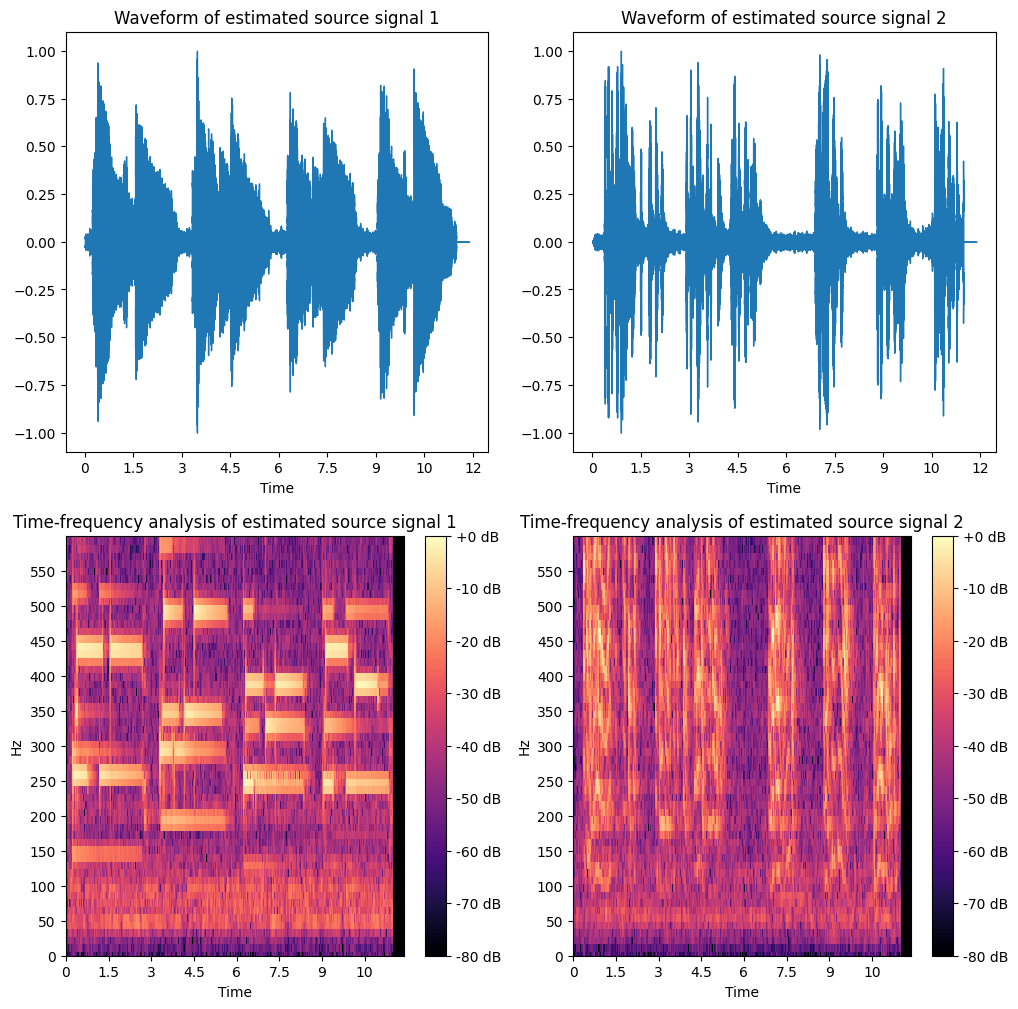

In [6]:
# แสดงไฟล์เสียงเป็นรูป waveform และ แสดงผลการวิเคราะห์ time-frequency analysis ด้วย spectrogram
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

for idx in range(n_components):

    # แสดง waveform
    librosa.display.waveshow(source_estimated[:, idx], sr=sampling_rate, ax=ax[0, idx])
    ax[0, idx].set(title=f"Waveform of estimated source signal {idx+1}")

    # แสดง spectrogram
    D = librosa.stft(source_estimated[:, idx])  # คำนวณ short-time fourier transform ของ source signal
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max) # แปลงหน่วยให้เป็น dB
    img = librosa.display.specshow(S_db, sr=sampling_rate, x_axis='time', y_axis='linear', ax=ax[1, idx])
    ax[1, idx].set(title=f"Time-frequency analysis of estimated source signal {idx+1}")
    ax[1, idx].set_ylim(0, 600)
    ax[1, idx].set_yticks(np.arange(0, 600, 50))
    fig.colorbar(img, ax=ax[1, idx], format="%+2.f dB")



หากเราสังเกตดูดี ๆ จะเห็นว่า estimated source signal ทั้งสองอันมี spectrogram ลักษณะที่แตกต่างกัน โดยอันที่เป็นของเสียง lecture จะมีการกระจายตัวกันของ ค่าความถี่ออกไปหลายค่าความถี่ ซึ่งเป็นลักษณะปกติที่จะเห็นได้จาก spectrogram ของเสียงการพูดคุยของมนุษย์

ส่วน spectrogram ของสัญญาณที่เป็นเสียงกีตาร์มีจุดน่าสังเกตหลายที่ เช่น

1.   ระยะเวลาระหว่าง 0 ถึง 3 วินาที spectrogram มีสีสว่าง (ขาว/เหลือง) ซึ่งแปลว่ามีค่าสูง ที่เห็นได้ชัดเป็นแถบที่ค่าความถี่ต่าง ๆ หากเราลองเอาค่าความถี่เหล่านี้มาเทียบกับค่าความถี่ของตัวโน้ต จะพบว่ามีค่าใกล้เคียงกับโน้ต D, C, F, A ซึ่งรวมกันเป็นคอร์ด Dm7 ตามที่ได้ถูกเล่นไว้ในไฟล์เสียง

2.   ระยะเวลาระหว่าง 3 ถึง 6 วินาที มีค่าความถี่ที่ใกล้เคียงกับตัวโน้ต G, D, F, B ซึ่งรวมกันเป็นคอร์ด G7

3.   ระยะเวลาระหว่าง 6 ถึง 9 วินาที มีค่าความถี่ที่ใกล้เคียงกับตัวโน้ต C, B, E, G ซึ่งรวมกันเป็นคอร์ด Cmaj7

4.   ที่เวลาประมาณ 9.5 วินาที ค่าความถี่ที่ประมาณ 440 Hz ได้หายไป และมีความถี่ที่ประมาณ 390 Hz โผล่กลับมา ซึ่งเป็นการเปลี่ยนจากโน้ตตัว A ไปเป็นโน้ตตัว G (มีการเปลี่ยนคอร์ดจาก Cmaj13 ไปเป็น Cmaj7)

จากตัวอย่างนี้จะเห็นได้ว่าการทำ time-frequency analysis โดยการดู spectrogram สามารถให้ข้อมูลที่ว่าสัญญาณของเรามีค่าความถี่ใด ที่เวลาใดบ้าง (ซึ่งเป็นสิ่งที่ Fourier transform แบบปกติ ไม่สามารถให้ได้)

ในตัวอย่างนี้ เราสามารถบอกได้แม้กระทั่งว่าใน source signal ที่เป็นเสียงกีตาร์ที่เราได้มาจาก ICA ผู้เล่นได้เล่นคอร์ดหรือตัวโน้ตอะไรบ้างที่เวลาต่าง ๆ ในไฟล์

ดูจากรูปคอร์ดที่เราแกะออกมาจาก spectrogram เราเดาได้ว่าคนนั้นน่าจะอยากเล่น jazz เป็น และกำลังฝึกทางเดินคอร์ดแบบ 2-5-1 ในคีย์ C อยู่ แต่สิ่งแรกที่เค้าน่าจะต้องทำคือตั้งสายกีตาร์ให้ตรงก่อนนะ!



**ผู้จัดเตรียม code ใน tutorial**: ดร. อิทธิ ฉัตรนันทเวช